# VANILLA AUTOENCODER WITH EUCLIDEAN DISTACE BASED LOSS
______

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import torch
from torch import nn
import torch.nn.functional as F
from typing import Optional, Tuple
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa    
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torchmetrics.regression import MeanSquaredError, MeanAbsolutePercentageError
#https://medium.com/intel-student-ambassadors/implementing-attention-models-in-pytorch-f947034b3e66from ray import train
from ray import train, tune
from ray.tune import ResultGrid
import pandas as pd
import skbio
from skbio import TreeNode
from io import StringIO
from ete3 import Tree
from skbio import diversity 
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from scipy.spatial.distance import braycurtis
import warnings
from collections import Counter
import concurrent.futures

from scipy.spatial import procrustes
warnings.filterwarnings("ignore")

In [70]:
plots_dir = '/Users/zkarwowska/Desktop/microbiome_gpt/autoencoders/plots/vanillaAE/distance_loss/'

In [62]:
#https://towardsdatascience.com/regularisation-techniques-neural-networks-101-1f746ad45b72

In [2]:
torch.cuda.empty_cache()

In [3]:
pathways = pd.read_csv('input_data/controls_pathways.csv', index_col= [0]).iloc[:, 2:].sort_index()
taxonomy = pd.read_csv('input_data/controls_taxonomy.csv', index_col= [0]).sort_index()
metadata = pd.read_csv('input_data/controls_metadata.csv', index_col= [0]).sort_index()

metadata = metadata[metadata['age_category'] == 'adult']

In [4]:
def filter_prevalence(df, treshold = 0.05):
    '''features as columns'''
    df_binary = df.copy()
    df_binary[df_binary>0]=1
    df_binary_sum = df_binary.sum(axis=0)
    
    keep_features = df_binary_sum[df_binary_sum > df.shape[0]*treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

def filter_on_abundance(df, abundance_treshold = 1e-3):
    '''features as columns'''
    df_relab = df.div(df.sum(axis=1), axis=0)
    df_relab_mean = df_relab.mean()

    keep_features = df_relab_mean[df_relab_mean > abundance_treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df


pathways = filter_on_abundance(filter_prevalence(pathways, 0.1))
taxonomy = filter_on_abundance(filter_prevalence(taxonomy, 0.1))

In [5]:
pathways = pathways.rank(axis=1, method='dense')
taxonomy = taxonomy.rank(axis=1, method='dense')

In [6]:
HMP_samples = metadata[metadata.study_name == 'HMP_2019_ibdmdb'].sample_id.values

HMP_pathways = pathways.loc[HMP_samples]
HMP_taxonomy = taxonomy.loc[HMP_samples]

HMP_taxonomy_relab = HMP_taxonomy.div(HMP_taxonomy.sum(axis=1), axis=0).fillna(0)
HMP_pathways_relab = HMP_pathways.div(HMP_pathways.sum(axis=1), axis=0).fillna(0)

In [7]:
other_samples = metadata[metadata.study_name != 'HMP_2019_ibdmdb'].sample_id.values

other_pathways = pathways.loc[other_samples]
other_taxonomy = taxonomy.loc[other_samples]

taxonomy_relab = other_taxonomy.div(other_taxonomy.sum(axis=1), axis=0).fillna(0)
pathways_relab = other_pathways.div(other_pathways.sum(axis=1), axis=0).fillna(0)

In [8]:
taxonomy_input = other_taxonomy.sample(2000, random_state=42).copy()
pathways_input = other_pathways.sample(2000, random_state=42).copy()

In [9]:
taxonomy_input.shape, pathways_input.shape

((2000, 106), (2000, 204))

In [ ]:

def replace_spaces_in_names_skbio(node):
    # Replace spaces with double underscores in the current node's name if it has one
    if node.name:
        node.name = node.name.replace(' ', '_')
    # Recursively apply this to all children
    for child in node.children:
        replace_spaces_in_names_skbio(child)

# Apply the function to your tree
replace_spaces_in_names_skbio(pruned_skbio_tree)

import numpy as np
from joblib import Parallel, delayed

num_samples = taxonomy.shape[0]

# Function to calculate distance for one pair
def calculate_distance(i, j):
    if j > i:  # Ensures we calculate only for the upper triangle
        distance = weighted_unifrac(taxonomy.iloc[i], taxonomy.iloc[j], otu_ids, pruned_skbio_tree)
        return i, j, distance
    return i, j, 0

# Initialize an empty matrix to store the distances
distance_matrix = np.zeros((num_samples, num_samples))

# Parallel computation of distances
results = Parallel(n_jobs=-1, verbose=10)(delayed(calculate_distance)(i, j) for i in range(num_samples) for j in range(i, num_samples))

# Fill the distance matrix using results
for i, j, distance in results:
    distance_matrix[i, j] = distance
    if i != j:  # Mirror the distance since the matrix is symmetric
        distance_matrix[j, i] = distance

wu_M = pd.DataFrame(distance_matrix, columns = taxonomy.index)
wu_M.index =  taxonomy.index

In [10]:
def apply_mask(input_data, mask_prob):
    mask = (torch.rand_like(input_data) > mask_prob).float()
    masked_input = input_data * mask
    return masked_input, mask

In [11]:
class VanillaAE(nn.Module):
    def __init__(self, input_dim1, input_dim2, hl1=64, feature_dim=16,l1_reg=0.00):
        super(VanillaAE, self).__init__()

        self.hl1 = hl1
        self.feature_dim = feature_dim
        self.l1_reg_value = l1_reg


        # Initial encoders for both inputs
        self.encoder_first_part1 = nn.Sequential(nn.Linear(input_dim1, hl1), nn.ReLU())
        self.encoder_first_part2 = nn.Sequential(nn.Linear(input_dim2, hl1), nn.ReLU())

        # Shared encoder part after concatenating features
        self.encoder_second_part = nn.Sequential(
            nn.Linear(hl1 * 2, feature_dim),  # Corrected to include feature_dim as output
            nn.ReLU()
        )

        # Decoders
        self.decoder1 = nn.Sequential(
            nn.Linear(feature_dim, hl1),
            nn.ReLU(),
            nn.Linear(hl1, input_dim1)
        )
        self.decoder2 = nn.Sequential(
            nn.Linear(feature_dim, hl1),
            nn.ReLU(),
            nn.Linear(hl1, input_dim2)
        )

        self.double()  # Ensure parameters are in double precision if needed

    def forward(self, x1, x2):
        
        # Encode inputs
        x1_encoded = self.encoder_first_part1(x1)
        x2_encoded = self.encoder_first_part2(x2)

        # Concatenate encoded features
        concatenated_features = torch.cat((x1_encoded, x2_encoded), dim=1)
        
        # Pass through the shared encoder
        encoded = self.encoder_second_part(concatenated_features)

        # Decode the features back to the original dimensions
        reconstructed1 = self.decoder1(encoded)
        reconstructed2 = self.decoder2(encoded)

        return reconstructed1, reconstructed2
    
    def l1_regularization(self):
        l1_loss = 0.0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return self.l1_reg_value * l1_loss

In [12]:
def prepare_data(df, test_size=0.2, random_state=42, scale=True):

    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    if scale == True:
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_df)
        X_test = scaler.transform(test_df)
    
    elif scale == False:
        X_train = train_df.copy()
        X_test = test_df.copy()
    
    train_tensor = torch.tensor(X_train, dtype=torch.float64)
    test_tensor = torch.tensor(X_test, dtype=torch.float64)
    
    train_dataset = torch.utils.data.TensorDataset(train_tensor, train_tensor)  
    test_dataset = torch.utils.data.TensorDataset(test_tensor, test_tensor)

    if scale == True:
        
        return scaler, train_dataset, test_dataset
    
    if scale == False:
        
        return [], train_dataset, test_dataset

### nn.PairwiseDistance(p=2)

p = 1: This results in the Manhattan distance (or L1 norm), which is the sum of the absolute differences of their Cartesian coordinates. p = 2 (default): This results in the Euclidean distance (or L2 norm), which is the most common choice, representing the straight line distance between two points. p = ∞ (infinity): This computes the Chebyshev distance, which is the maximum difference along any coordinate dimension.

In [13]:
## custom loss function
def euclidean_distance_matrix(x):
    n = x.size(0)
    x = x.view(n, -1)
    distances = torch.cdist(x, x, p=2)
    return distances

def distance_matrix_loss(decoded_distances, true_distances):
    loss = nn.MSELoss()
    return loss(decoded_distances, true_distances)

In [14]:
def train_ae(config):
    
    checkpoint_dir = '.'
    model = VanillaAE(input_dim1=taxonomy_input.shape[1], 
                                 input_dim2=pathways_input.shape[1],
                                 hl1=config["hl1"], 
                                 feature_dim=config["feature_dim"],
                                 l1_reg = config["l1_reg"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
            
    model.to(device)
    
    # Assuming the reconstruction loss for both outputs is important
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    metric = MeanSquaredError()
    
    _, taxonomy_train_dataset, taxonomy_test_dataset = prepare_data((taxonomy_input))
    _, pathways_train_dataset, pathways_test_dataset = prepare_data((pathways_input))

    taxonomy_train_loader = torch.utils.data.DataLoader(taxonomy_train_dataset, batch_size=config['batch_size'], shuffle=True)
    taxonomy_test_loader = torch.utils.data.DataLoader(taxonomy_test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    pathways_train_loader = torch.utils.data.DataLoader(pathways_train_dataset, batch_size=config['batch_size'], shuffle=True)
    pathways_test_loader = torch.utils.data.DataLoader(pathways_test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    
    for epoch in range(100):
        
        model.train()
        running_loss = 0.0
        epoch_steps = 0.0
        t_MSE = 0.0
        p_MSE = 0.0
        
        for (t_data, t_target), (p_data, p_target)  in zip(taxonomy_train_loader, pathways_train_loader):
            
            t_data, t_target = t_data.to(device), t_target.to(device)
            p_data, p_target = p_data.to(device), p_target.to(p_target)
        
            masked_input1, mask1 = apply_mask(t_data, 0.15)
            masked_input2, mask2 = apply_mask(p_data, 0.15)
        
            optimizer.zero_grad()
        
            output1, output2 = model(masked_input1, masked_input2)
            
            taxonomy_mse = metric(output1, t_target)
            pathways_mse = metric(output2, p_target)
            
            true_dMt = euclidean_distance_matrix(t_data)
            true_dMp = euclidean_distance_matrix(p_data)

            decoded_dMt = euclidean_distance_matrix(output1)
            decoded_dMp = euclidean_distance_matrix(output2)

            p_loss = distance_matrix_loss(decoded_dMt, true_dMt)
            t_loss = distance_matrix_loss(decoded_dMp, true_dMp)

            loss = p_loss + t_loss / 2         
            
            loss.backward()
            optimizer.step()
                
            running_loss += loss.item()
            t_MSE += taxonomy_mse.item()
            p_MSE += pathways_mse.item()
            epoch_steps += 1
            
            
        model.eval()
        test_loss = 0.0 
        test_steps = 0.0
        test_t_MSE = 0.0
        test_p_MSE = 0.0
        
        with torch.no_grad():    
            for (t_data, t_target), (p_data, p_target)  in zip(taxonomy_test_loader, pathways_test_loader):
            
                t_data, t_target = t_data.to(device), t_target.to(device)
                p_data, p_target = p_data.to(device), p_target.to(p_target)
            
                masked_input1, mask1 = apply_mask(t_data, 0.15)
                masked_input2, mask2 = apply_mask(p_data, 0.15)
                    
                output1, output2 = model(masked_input1, masked_input2)

                taxonomy_mse = metric(output1, t_target)
                pathways_mse = metric(output2, p_target)
            
                true_dMt = euclidean_distance_matrix(t_data)
                true_dMp = euclidean_distance_matrix(p_data)

                decoded_dMt = euclidean_distance_matrix(output1)
                decoded_dMp = euclidean_distance_matrix(output2)

                p_loss = distance_matrix_loss(decoded_dMt, true_dMt)
                t_loss = distance_matrix_loss(decoded_dMp, true_dMp)

                loss = p_loss + t_loss / 2 
                
                test_loss += loss.item()
                test_t_MSE += taxonomy_mse.item()
                test_p_MSE += pathways_mse.item()
                test_steps += 1
                
        train.report({'loss':running_loss/epoch_steps, 
                      't_mse':t_MSE/epoch_steps,
                      'p_mse':p_MSE/epoch_steps,
                      'test_loss':test_loss/test_steps,
                     'test_t_mse':test_t_MSE/test_steps,
                      'test_p_mse':test_p_MSE/test_steps})
            
        print("Finished Training")

In [ ]:
config = {
    "hl1": tune.choice([128, 64, 32, 16]),
    "feature_dim": tune.choice([32, 16, 8, 4]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32, 64, 128]),
    "l1_reg": tune.choice([0, 0.1, 0.25, 0.5, 0.7])}

scheduler = ASHAScheduler(
    max_t=50,
    grace_period=10,
    reduction_factor=2,
    )

tuner = tune.Tuner(
    train_ae,
    param_space=config,
    run_config=train.RunConfig(
        name='test',
        stop={"training_iteration": 50},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="loss",
            num_to_keep=5,
        ),
        storage_path=None,
    ),
    tune_config=tune.TuneConfig(mode="min", metric="test_loss", num_samples=50, scheduler=scheduler),
)
result_grid: ResultGrid = tuner.fit()

In [18]:
best_checkpoint = result_grid.get_best_result(metric = 'test_loss')
best_params = best_checkpoint.config

In [19]:
best_checkpoint

Result(
  metrics={'loss': 3.3619325727357885, 't_mse': 2.9592084455490113, 'p_mse': 2.9993300557136537, 'test_loss': 5.213518121785524, 'test_t_mse': 3.0899498748779295, 'test_p_mse': 2.894149398803711},
  path='/Users/zkarwowska/ray_results/test/train_ae_3dc77_00003_3_batch_size=16,feature_dim=32,hl1=128,l1_reg=0,lr=0.0009_2024-05-02_11-06-27',
  filesystem='local',
  checkpoint=None
)

In [20]:
pathways_input.shape, taxonomy_input.shape

((2000, 204), (2000, 106))

In [22]:
t_scaler, taxonomy_train_dataset, taxonomy_test_dataset = prepare_data(taxonomy_input)
p_scaler, pathways_train_dataset, pathways_test_dataset = prepare_data(pathways_input)

model = VanillaAE(input_dim1=taxonomy_input.shape[1], 
                  input_dim2=pathways_input.shape[1], 
                  hl1=best_params['hl1'], 
                  feature_dim=best_params['feature_dim'],
                  l1_reg = best_params["l1_reg"])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        
model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
metric = MeanSquaredError()

batch_size = best_params['batch_size']
taxonomy_train_loader = torch.utils.data.DataLoader(taxonomy_train_dataset, batch_size=batch_size, shuffle=False)
taxonomy_test_loader = torch.utils.data.DataLoader(taxonomy_test_dataset, batch_size=batch_size, shuffle=False)

pathways_train_loader = torch.utils.data.DataLoader(pathways_train_dataset, batch_size=batch_size, shuffle=False)
pathways_test_loader = torch.utils.data.DataLoader(pathways_test_dataset, batch_size=batch_size, shuffle=False)

results = []
for epoch in range(200):

    model.train()
    running_loss = 0.0
    epoch_steps = 0.0
    t_MSE = 0.0
    p_MSE = 0.0
    
    for (t_data, t_target), (p_data, p_target) in zip(taxonomy_train_loader, pathways_train_loader):
        
        t_data, t_target = t_data.to(device), t_target.to(device)
        p_data, p_target = p_data.to(device), p_target.to(p_target)
    
        masked_input1, mask1 = apply_mask(t_data, 0.15)
        masked_input2, mask2 = apply_mask(p_data, 0.15)
    
        optimizer.zero_grad()
    
        output1, output2 = model(masked_input1, masked_input2)
        
        true_dMt = euclidean_distance_matrix(t_data)
        true_dMp = euclidean_distance_matrix(p_data)

        decoded_dMt = euclidean_distance_matrix(output1)
        decoded_dMp = euclidean_distance_matrix(output2)

        p_loss = distance_matrix_loss(decoded_dMt, true_dMt)
        t_loss = distance_matrix_loss(decoded_dMp, true_dMp)

        loss = p_loss + t_loss 


        taxonomy_mse = metric(output1, t_target)
        pathways_mse = metric(output2, p_target)
        
        loss.backward()
        optimizer.step()
            
        running_loss += loss.item()
        t_MSE += taxonomy_mse.item()
        p_MSE += pathways_mse.item()
        epoch_steps += 1
        
            
    model.eval()
    test_loss = 0.0 
    test_steps = 0.0
    test_t_MSE = 0.0
    test_p_MSE = 0.0
    
    with torch.no_grad():
        
        for (t_data, t_target), (p_data, p_target) in zip(taxonomy_test_loader, pathways_test_loader):
        
            t_data, t_target = t_data.to(device), t_target.to(device)
            p_data, p_target = p_data.to(device), p_target.to(p_target)
        
            masked_input1, mask1 = apply_mask(t_data, 0.15)
            masked_input2, mask2 = apply_mask(p_data, 0.15)

            output1, output2 = model(masked_input1, masked_input2)

            taxonomy_mse = metric(output1, t_target)
            pathways_mse = metric(output2, p_target)
        
            true_dMt = euclidean_distance_matrix(t_data)
            true_dMp = euclidean_distance_matrix(p_data)

            decoded_dMt = euclidean_distance_matrix(output1)
            decoded_dMp = euclidean_distance_matrix(output2)

            p_loss = distance_matrix_loss(decoded_dMt, true_dMt)
            t_loss = distance_matrix_loss(decoded_dMp, true_dMp)

            loss = p_loss + t_loss 

            test_loss += loss.item()
            test_t_MSE += taxonomy_mse.item()
            test_p_MSE += pathways_mse.item()
            test_steps += 1
    
    results.append({'epoch':epoch,
                    'loss':running_loss/epoch_steps,
                    't_MSE':t_MSE/epoch_steps,
                    'p_MSE':p_MSE/epoch_steps,
                    'test_loss':test_loss/test_steps,
                    'test_t_MSE':test_t_MSE/test_steps,
                    'test_p_MSE':test_p_MSE/test_steps})

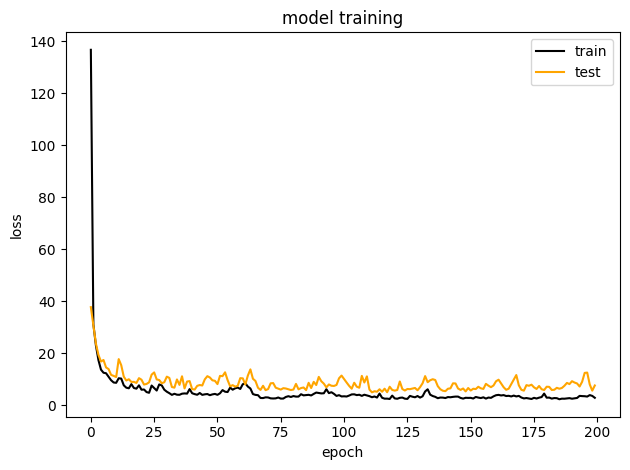

In [71]:
history = pd.DataFrame(results)

sns.lineplot(x = history.epoch, y = history.loss, color = 'k', label = 'train')
sns.lineplot(x = history.epoch, y = history.test_loss, color = 'orange', label = 'test')
plt.title('model training')
plt.tight_layout()
plt.savefig(plots_dir + 'history.png', dpi=300)

### SHOW DATA ON VAL DATASET

In [72]:
taxonomy_val = HMP_taxonomy.copy() 
pathways_val = HMP_pathways.copy()

In [73]:
taxonomy_val_sc = t_scaler.transform(taxonomy_val)#np.log(taxonomy_val+1e-2))
taxonomy_val_sc_tensor = torch.tensor(taxonomy_val_sc, dtype=torch.float64)
taxonomy_val_masked, mask = apply_mask(taxonomy_val_sc_tensor, 0.15)

pathway_val_sc = p_scaler.transform(pathways_val)#np.log(pathways_val+1e-2))
pathway_val_sc_tensor = torch.tensor(pathway_val_sc, dtype=torch.float64)
pathway_val_masked, mask = apply_mask(pathway_val_sc_tensor, 0.15)

In [75]:
output1, output2 = model(taxonomy_val_masked, pathway_val_masked)

In [76]:
HMP_metadata = metadata[metadata.sample_id.isin(HMP_samples)]
subject_hue = HMP_metadata.subject_id.values

In [77]:
t_decoded = t_scaler.inverse_transform(output1.detach().numpy())#np.exp(t_scaler.inverse_transform(output1.detach().numpy()))-1e-2
p_decoded = p_scaler.inverse_transform(output2.detach().numpy())#np.exp(p_scaler.inverse_transform(output2.detach().numpy()))-1e-2

t_decoded[t_decoded<0]=0
p_decoded[p_decoded<0]=0

p_decoded_df = pd.DataFrame(p_decoded, columns = pathways_val.columns)
t_decoded_df = pd.DataFrame(t_decoded, columns = taxonomy_val.columns)

p_decoded_df.index = pathways_val.index
t_decoded_df.index = taxonomy_val.index

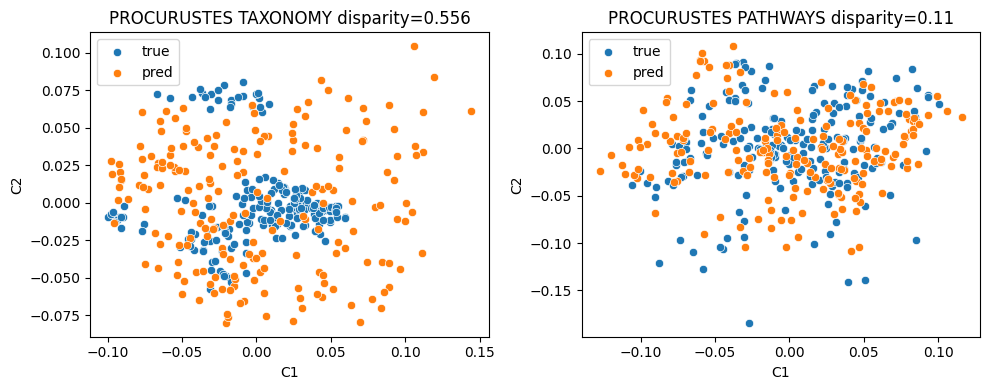

In [80]:
t_decoded_pcoa = pcoa(squareform(pdist((t_decoded_df), 'braycurtis'))).samples.iloc[:, :2]
t_true_pcoa = pcoa(squareform(pdist((taxonomy_val), 'braycurtis'))).samples.iloc[:, :2]
p_decoded_pcoa = pcoa(squareform(pdist((p_decoded_df), 'braycurtis'))).samples.iloc[:, :2]
p_true_pcoa = pcoa(squareform(pdist((pathways_val), 'braycurtis'))).samples.iloc[:, :2]

Tmtx1, Tmtx2, Tdisp = procrustes(t_decoded_pcoa, t_true_pcoa)
Pmtx1, Pmtx2, Pdisp = procrustes(p_decoded_pcoa, p_true_pcoa)

fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.scatterplot(x = Tmtx2[:, 0], y = Tmtx2[:, 1], ax=axes[0], label = 'true')
sns.scatterplot(x = Tmtx1[:, 0], y = Tmtx1[:, 1], ax=axes[0], label = 'pred')

sns.scatterplot(x = Pmtx2[:, 0], y = Pmtx2[:, 1], ax=axes[1], label = 'true')
sns.scatterplot(x = Pmtx1[:, 0], y = Pmtx1[:, 1], ax=axes[1], label = 'pred')

axes[0].set_xlabel('C1')
axes[0].set_ylabel('C2')

axes[1].set_xlabel('C1')
axes[1].set_ylabel('C2')

plt.tight_layout()

axes[0].set_title(f'PROCURUSTES TAXONOMY disparity={np.round(Tdisp, 3)}')
axes[1].set_title(f'PROCURUSTES PATHWAYS disparity={np.round(Pdisp, 3)}')

plt.tight_layout()
plt.savefig(plots_dir + 'bc_procrustes.png', dpi=300)

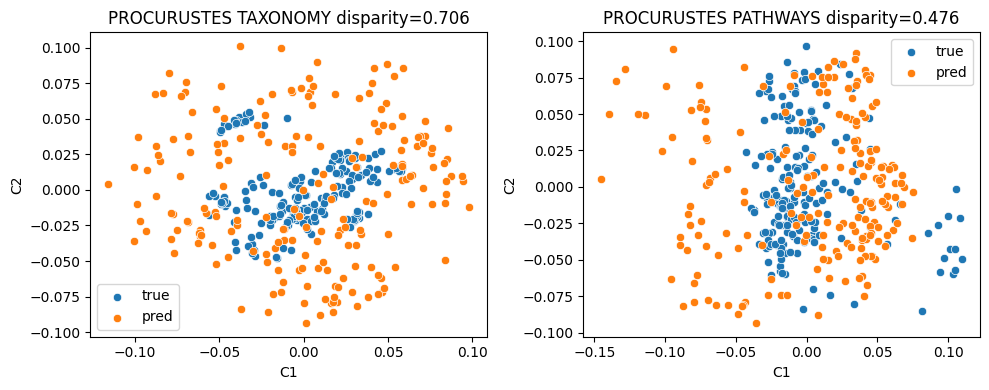

In [81]:
t_decoded_pcoa = pcoa(squareform(pdist(np.log(t_decoded_df+1e-2), 'euclidean'))).samples.iloc[:, :2]
t_true_pcoa = pcoa(squareform(pdist(np.log(taxonomy_val+1e-2), 'euclidean'))).samples.iloc[:, :2]
p_decoded_pcoa = pcoa(squareform(pdist(np.log(p_decoded_df+1e-2), 'euclidean'))).samples.iloc[:, :2]
p_true_pcoa = pcoa(squareform(pdist(np.log(pathways_val+1e-2), 'euclidean'))).samples.iloc[:, :2]

Tmtx1, Tmtx2, Tdisp = procrustes(t_decoded_pcoa, t_true_pcoa)
Pmtx1, Pmtx2, Pdisp = procrustes(p_decoded_pcoa, p_true_pcoa)

fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.scatterplot(x = Tmtx2[:, 0], y = Tmtx2[:, 1], ax=axes[0], label = 'true')
sns.scatterplot(x = Tmtx1[:, 0], y = Tmtx1[:, 1], ax=axes[0], label = 'pred')

sns.scatterplot(x = Pmtx2[:, 0], y = Pmtx2[:, 1], ax=axes[1], label = 'true')
sns.scatterplot(x = Pmtx1[:, 0], y = Pmtx1[:, 1], ax=axes[1], label = 'pred')

axes[0].set_xlabel('C1')
axes[0].set_ylabel('C2')

axes[1].set_xlabel('C1')
axes[1].set_ylabel('C2')

plt.tight_layout()

axes[0].set_title(f'PROCURUSTES TAXONOMY disparity={np.round(Tdisp, 3)}')
axes[1].set_title(f'PROCURUSTES PATHWAYS disparity={np.round(Pdisp, 3)}')

plt.tight_layout()
plt.savefig(plots_dir + 'euclidean_procrustes.png', dpi=300)

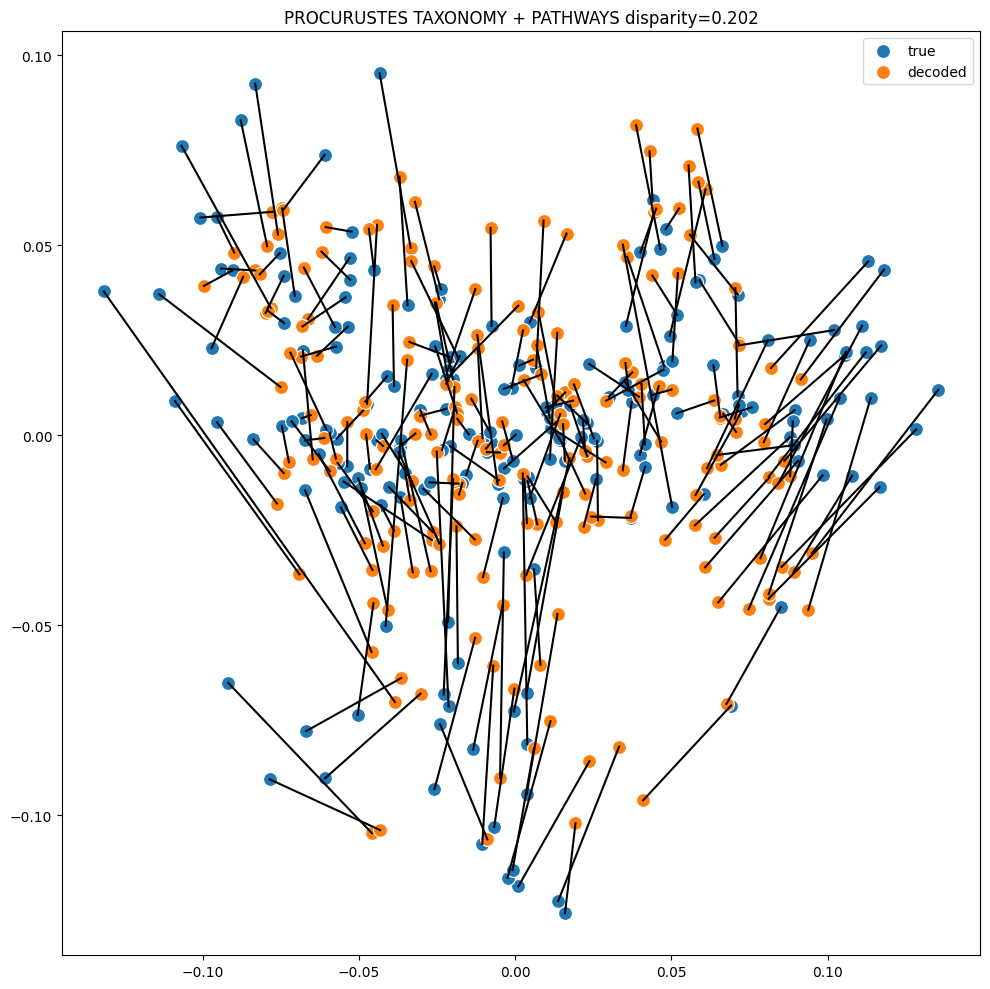

In [82]:
decoded_df = pd.concat([t_decoded_df, p_decoded_df],axis=1)
decoded_relab = decoded_df.div(decoded_df.sum(axis=1), axis=0)
true_df = pd.concat([taxonomy_val, pathways_val],axis=1)
true_relab = true_df.div(true_df.sum(axis=1), axis=0)

decoded_pcoa = pcoa(squareform(pdist(np.log(decoded_relab+1e-2), 'euclidean'))).samples.iloc[:, :2]
true_pcoa = pcoa(squareform(pdist(np.log(true_relab+1e-2), 'euclidean'))).samples.iloc[:, :2]

A, B, disp = procrustes(true_pcoa, decoded_pcoa)

plt.figure(figsize = (10, 10))
sns.scatterplot(x = A[:, 0], y = A[:, 1], label = 'true', s=100)
sns.scatterplot(x = B[:, 0], y = B[:, 1], label = 'decoded', s=100)

for i in range(len(A)):
    plt.plot([A[i][0], B[i][0]], [A[i][1], B[i][1]], 'black', linestyle='-')  # Connect with dashed gray lines

plt.title(f'PROCURUSTES TAXONOMY + PATHWAYS disparity={np.round(disp, 3)}')
plt.tight_layout()
plt.savefig(plots_dir + 'procrustes.png', dpi=300)

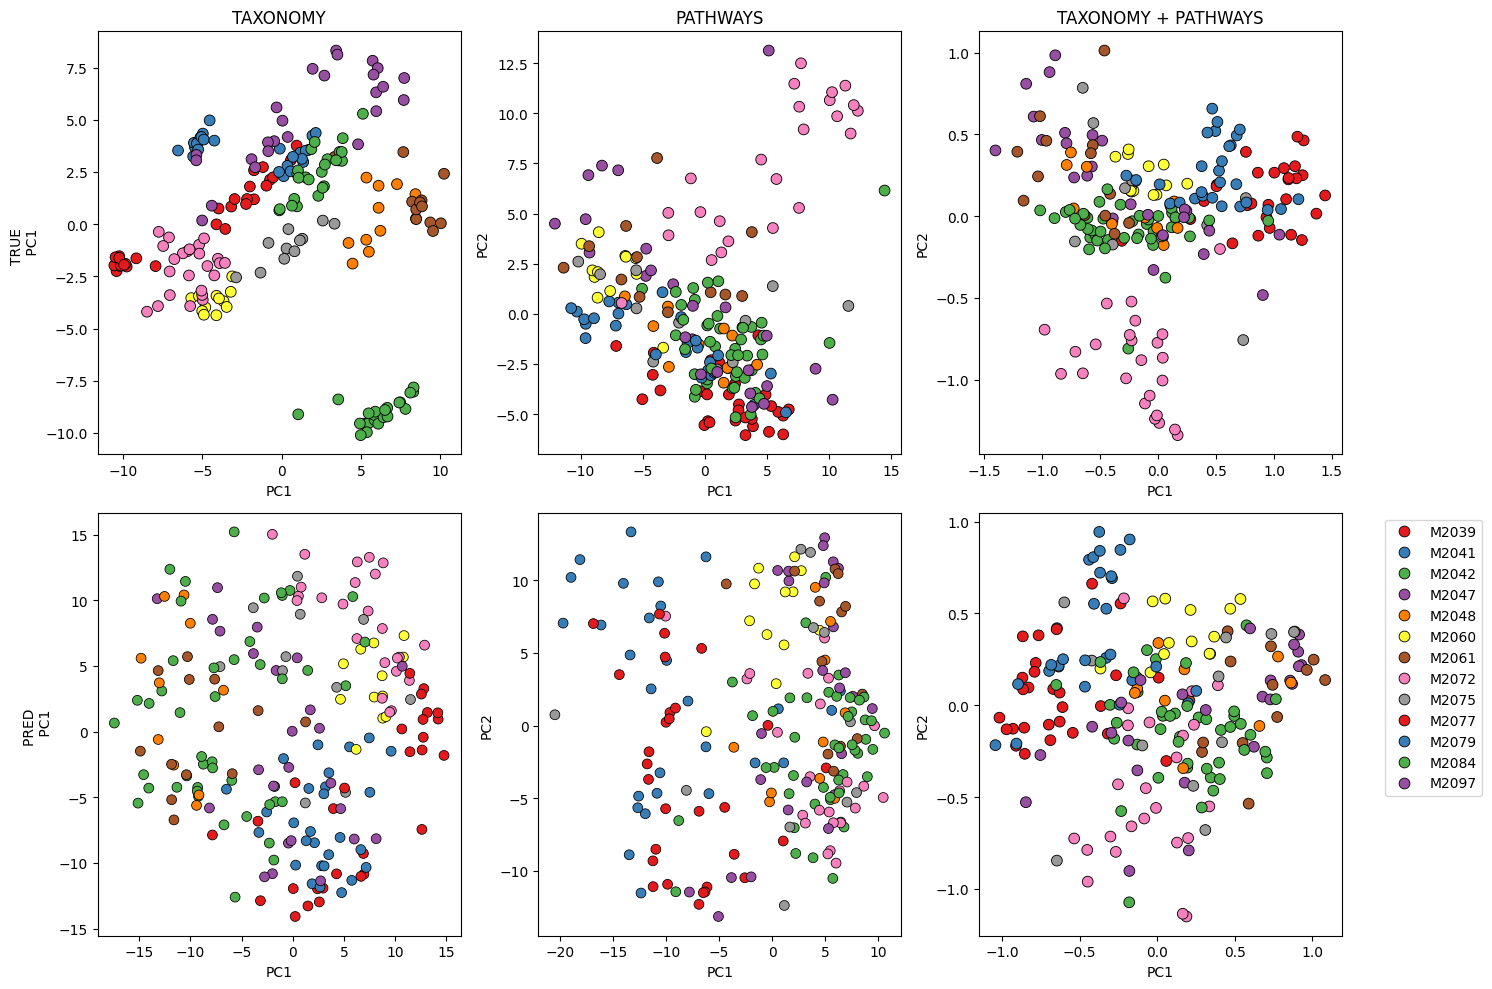

In [83]:
fig, axes = plt.subplots(2, 3, figsize = (15, 10))

sns.scatterplot(x = t_true_pcoa.PC1, y=t_true_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=60, ax=axes[0, 0], legend=False, edgecolor='k')
sns.scatterplot(x = p_true_pcoa.PC1, y=p_true_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=60, ax=axes[0, 1], legend=False, edgecolor='k')
sns.scatterplot(x = true_pcoa.PC1, y=true_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=60, ax=axes[0, 2], legend=False, edgecolor='k')

sns.scatterplot(x = t_decoded_pcoa.PC1, y=t_decoded_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=50, ax=axes[1, 0], legend=False, edgecolor='k')
sns.scatterplot(x = p_decoded_pcoa.PC1, y=p_decoded_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=50, ax=axes[1, 1], legend=False, edgecolor='k')
sns.scatterplot(x = decoded_pcoa.PC1, y=decoded_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=60, ax=axes[1, 2], edgecolor='k')

axes[0, 0].set_ylabel(f'TRUE \n PC1')
axes[1, 0].set_ylabel(f'PRED \n PC1')

axes[0, 0].set_title(f'TAXONOMY')
axes[0, 1].set_title(f'PATHWAYS')
axes[0, 2].set_title(f'TAXONOMY + PATHWAYS')

plt.legend(bbox_to_anchor = (1.1, 1))
plt.tight_layout()
plt.savefig(plots_dir + 'pcoa.png', dpi=300)

## LATENT

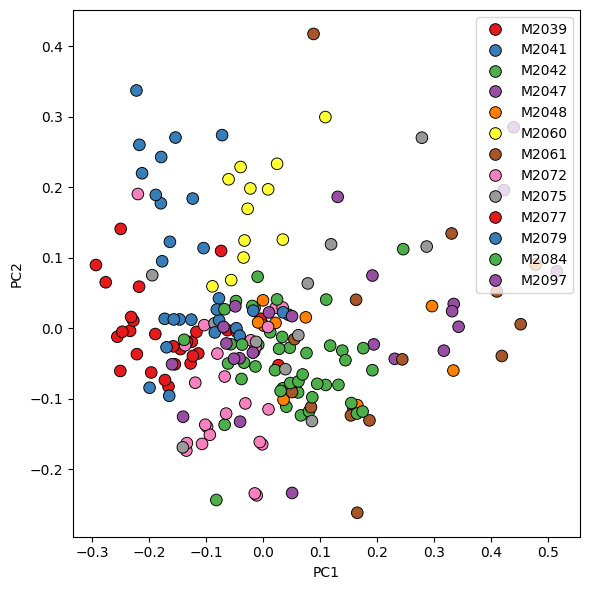

In [84]:
#HMP_data.subject_id.tolist()

# LATENT
l1 = model.encoder_first_part1(taxonomy_val_sc_tensor)
l2 = model.encoder_first_part2(pathway_val_sc_tensor)

concatenated_features = torch.cat((l1, l2), dim=1)
encoded = model.encoder_second_part(concatenated_features)

pcoa_df = pcoa(squareform(pdist(encoded.detach().numpy(), 'cosine'))).samples.iloc[:, :3]

plt.figure(figsize = (6, 6))
sns.scatterplot(x = pcoa_df['PC1'], y = pcoa_df['PC2'], hue = subject_hue.tolist(), legend=True, edgecolor='k', s=70,  palette = 'Set1')
plt.tight_layout()
#plt.savefig('plots/vanillaAE/latent.png', dpi=300)

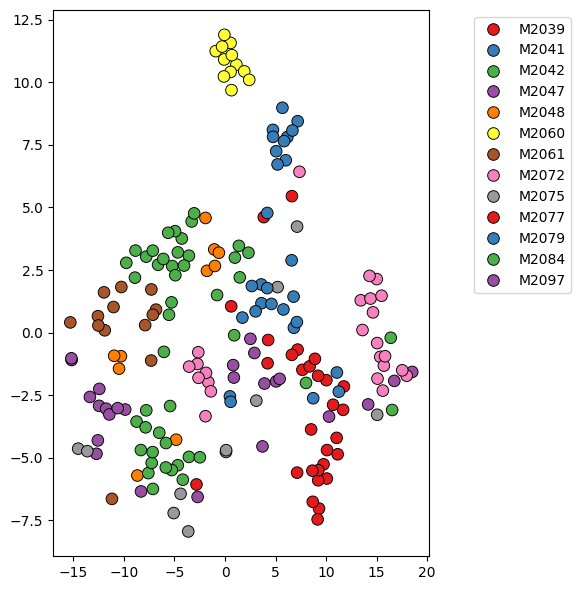

In [85]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne_embedding = tsne.fit_transform(encoded.detach().numpy())

plt.figure(figsize = (6, 6))
sns.scatterplot(x = tsne_embedding[:, 0], y = tsne_embedding[:, 1], hue = subject_hue.tolist(), legend=True, edgecolor='k', s=70,  palette = 'Set1')
plt.legend(bbox_to_anchor = (1.1, 1))
plt.tight_layout()
plt.savefig(plots_dir + 'latent_pcoa.png', dpi=300)

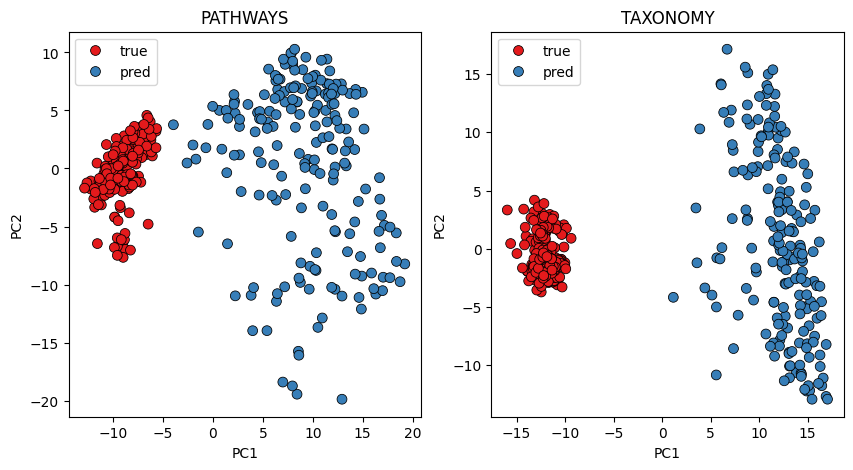

In [86]:
pathways_val['data'] = 'true'
p_decoded_df['data'] = 'pred'

pathways_df = pd.concat([pathways_val, p_decoded_df], axis=0)
pathways_pcoa = pcoa(squareform(pdist(np.log(pathways_df.set_index('data')+1e-2), 'euclidean'))).samples

taxonomy_val['data'] = 'true'
t_decoded_df['data'] = 'pred'

taxonomy_df = pd.concat([taxonomy_val, t_decoded_df], axis=0)
taxonomy_pcoa = pcoa(squareform(pdist(np.log(taxonomy_df.set_index('data')+1e-2), 'euclidean'))).samples

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(x = pathways_pcoa.PC1, y=pathways_pcoa.PC2, hue = pathways_df.data.values, palette = 'Set1', s=50, legend=True, edgecolor='k', ax=axes[0])
sns.scatterplot(x = taxonomy_pcoa.PC1, y=taxonomy_pcoa.PC2, hue = pathways_df.data.values, palette = 'Set1', s=50, legend=True, edgecolor='k', ax=axes[1])

axes[0].set_title('PATHWAYS')
axes[1].set_title('TAXONOMY')

plt.savefig(plots_dir + 'pcoa_juxtaposition.png', dpi=300)